# Embeddings

The main notebook for generating analysis and plots for research question 3

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import pickle

from typing import Dict
from collections import Counter

from config import EPSG_MAPPING, PLOTS_DIR
from src.DataBaseManager import DBMS
from src.embeddings import embeddings

In [2]:
# Generate embeddings
verbose_level = False
Denmark_embedded = embeddings.generate("Denmark", verbose=verbose_level)
Netherlands_embedded = embeddings.generate("Netherlands", verbose=verbose_level)
Israel_embedded = embeddings.generate("Israel", verbose=verbose_level)
Estonia_embedded = embeddings.generate("Estonia", verbose=verbose_level)

# combine embeddings to a single dict
country_embeddings = {
    "Denmark": Denmark_embedded["Denmark"],
    "Israel": Israel_embedded["Israel"],
    "Netherlands": Netherlands_embedded["Netherlands"],
    "Estonia": Estonia_embedded["Estonia"],
}

In [3]:
# convert countries to combined matrix
X, index_2_chip, colors = embeddings.dict_to_matrix(country_embeddings)

In [4]:
file_path = PLOTS_DIR / "embeddings/country_chips_greater_than.pickle"

load_from_db = False
country_chips_greater_than: Dict[int, pd.DataFrame] = {}

if file_path.exists():
    print("Loading embeddings from file")
    with open(file_path, "rb") as f:
        country_chips_greater_than = pickle.load(f)

    # Check if all four countries are in the file
    for country in country_embeddings.keys():
        if country not in country_chips_greater_than:
            print(f"Not all countries in file. Extending from database")
            load_from_db = True
            break

if load_from_db:
    print("Generating embeddings from database")
    # Exclude chips smaller than 80 km^2

    dbms = DBMS()

    for country in country_embeddings.keys():
        if country in country_chips_greater_than:
            print(f"Skipping {country}")
            continue

        print(f"Generating embeddings for {country}")
        yo = dbms.read(
            query_name="chip_greater_than",
            params={
                "__KILOMETER_THRESHOLD__": "80",
                "__COUNTRY__": str(country),
                "__EPSG__": str(EPSG_MAPPING[country]),
            },
        )
        country_chips_greater_than[country] = yo

        with open(file_path, "wb") as f:
            pickle.dump(country_chips_greater_than, f)

Loading embeddings from file


In [5]:
# how many chips are there for each country
for country, chips in country_chips_greater_than.items():
    print(f"{country}: {len(chips)}")

Denmark: 330
Israel: 168
Netherlands: 280
Estonia: 379


In [6]:
import numpy as np

# Remove the chips that are not included in country_chips_greater_than from X.
# In that, make sure to update index_2_chip and colors as well

remove_these = []
for idx, (country, chip_id) in index_2_chip.items():
    country_chips = set(country_chips_greater_than[country]["chipid"].values)

    if chip_id not in country_chips:
        # Remove the chip from the matrix
        remove_these.append(idx)


reduced_X = np.delete(X, remove_these, axis=0)
reduced_colors = np.delete(colors, remove_these, axis=0)

# Update index_2_chip
new_index_2_chip = {}
for idx, (country, chip_id) in index_2_chip.items():
    if idx not in remove_these:
        new_index_2_chip[len(new_index_2_chip)] = (country, chip_id)

index_2_chip = new_index_2_chip

In [7]:
Counter([country for _, (country, _) in index_2_chip.items()])

Counter({'Estonia': 379, 'Denmark': 330, 'Netherlands': 280, 'Israel': 142})

In [8]:
from src.data.utils import save_json

# save index_2_chip
save_json(index_2_chip, PLOTS_DIR / "embeddings/index_2_chip.json")

In [9]:
# Scale the data
X_scaled: np.ndarray = embeddings.scale(reduced_X)

Scaled data from (1131, 100) to (1131, 100).
The scaled data has a mean of -0.00 and a standard deviation of 0.91.


In [10]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from typing import Dict
from tqdm import tqdm


def optimal_q_and_K(
    X_scaled: np.ndarray, max_K: int = 10
) -> Dict[int, Dict[int, float]]:
    max_q = X_scaled.shape[1]  # Maximum q is the number of original features
    results = {}

    for q in tqdm(
        range(2, max_q + 1)
    ):  # Iterate over each possible number of dimensions
        X_projected = embeddings.project(
            X_scaled, q, verbose=False
        )  # Project data to q dimensions
        results[q] = {}

        for K in range(2, max_K + 1):  # Iterate over each possible number of clusters
            kmeans = KMeans(n_clusters=K, random_state=0)
            cluster_labels = kmeans.fit_predict(X_projected)
            silhouette_avg = silhouette_score(X_projected, cluster_labels)
            results[q][K] = silhouette_avg  # Store the silhouette score

    return results


optimal_results = optimal_q_and_K(X_scaled)

100%|██████████| 99/99 [05:47<00:00,  3.51s/it]


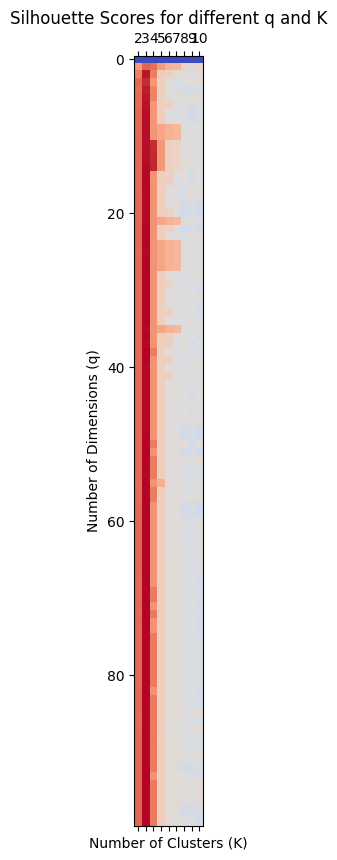

Max silhouette score: 0.7987744212150574
Optimal q: 93
Optimal K: 3
Max silhouette score: 0.6011406779289246
Optimal q: 14
Optimal K: 5


In [11]:
import matplotlib.pyplot as plt
import numpy as np


def plot_optimal_results(optimal_results):
    # Convert the nested dictionary into a 2D array for heatmap plotting
    max_q = max(optimal_results.keys())
    max_K = max(max(k for k in v.keys()) for v in optimal_results.values())

    silhouette_scores = np.zeros((max_q, max_K - 1))  # Adjust for K starting from 2

    for q in optimal_results:
        for K in optimal_results[q]:
            silhouette_scores[q - 1, K - 2] = optimal_results[q][
                K
            ]  # Adjust indices for 0-based index

    # Create the heatmap
    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.matshow(silhouette_scores, interpolation="nearest", cmap="coolwarm")
    # fig.colorbar(cax)

    # Set the x-axis labels
    ax.set_xticklabels([""] + list(range(2, max_K + 1)))

    # Axis titles
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Number of Dimensions (q)")
    plt.title("Silhouette Scores for different q and K")

    plt.show()


# Assuming 'optimal_results' is the output from your optimal_q_and_K function
plot_optimal_results(optimal_results)

# What is the k > 4 that has the highest silhouette score?
max_silhouette_score = -1
max_q = -1
max_K = -1

for q in optimal_results:
    for K in optimal_results[q]:
        if optimal_results[q][K] > max_silhouette_score:
            max_silhouette_score = optimal_results[q][K]
            max_q = q
            max_K = K

print(f"Max silhouette score: {max_silhouette_score}")
print(f"Optimal q: {max_q}")
print(f"Optimal K: {max_K}")

max_silhouette_score = -1
max_q = -1
max_K = -1

for q in optimal_results:
    for K in optimal_results[q]:
        if K <= 4:
            continue
        if optimal_results[q][K] > max_silhouette_score:
            max_silhouette_score = optimal_results[q][K]
            max_q = q
            max_K = K

print(f"Max silhouette score: {max_silhouette_score}")
print(f"Optimal q: {max_q}")
print(f"Optimal K: {max_K}")

In [12]:
# Project embeddings with Pacmap
X_projected = embeddings.project(X_scaled, n_components=14)

Projected data into from (1131, 100) to (1131, 14).


In [13]:
# Cluster projected embeddings
clustered = embeddings.cluster(X_projected, n_clusters=5)

Trained kmeans with 5 clusters on data with shape (1131, 14).


In [14]:
# Save the mapping of chips to clusters
chips_in_clusters = {}
for i, cluster_idx in enumerate(clustered.labels_):
    if cluster_idx not in chips_in_clusters:
        chips_in_clusters[int(cluster_idx)] = []
    chips_in_clusters[int(cluster_idx)].append(index_2_chip[i])

save_json(chips_in_clusters, PLOTS_DIR / "embeddings/chips_in_clusters.json")

# Plot the embeddings and clusters

In [15]:
from src.embeddings import plot

Projected data into from (1131, 100) to (1131, 2).
Saving plot to /Users/viktorduepedersen/Documents/github/thesis/plots/embeddings/projection_and_clusters.png


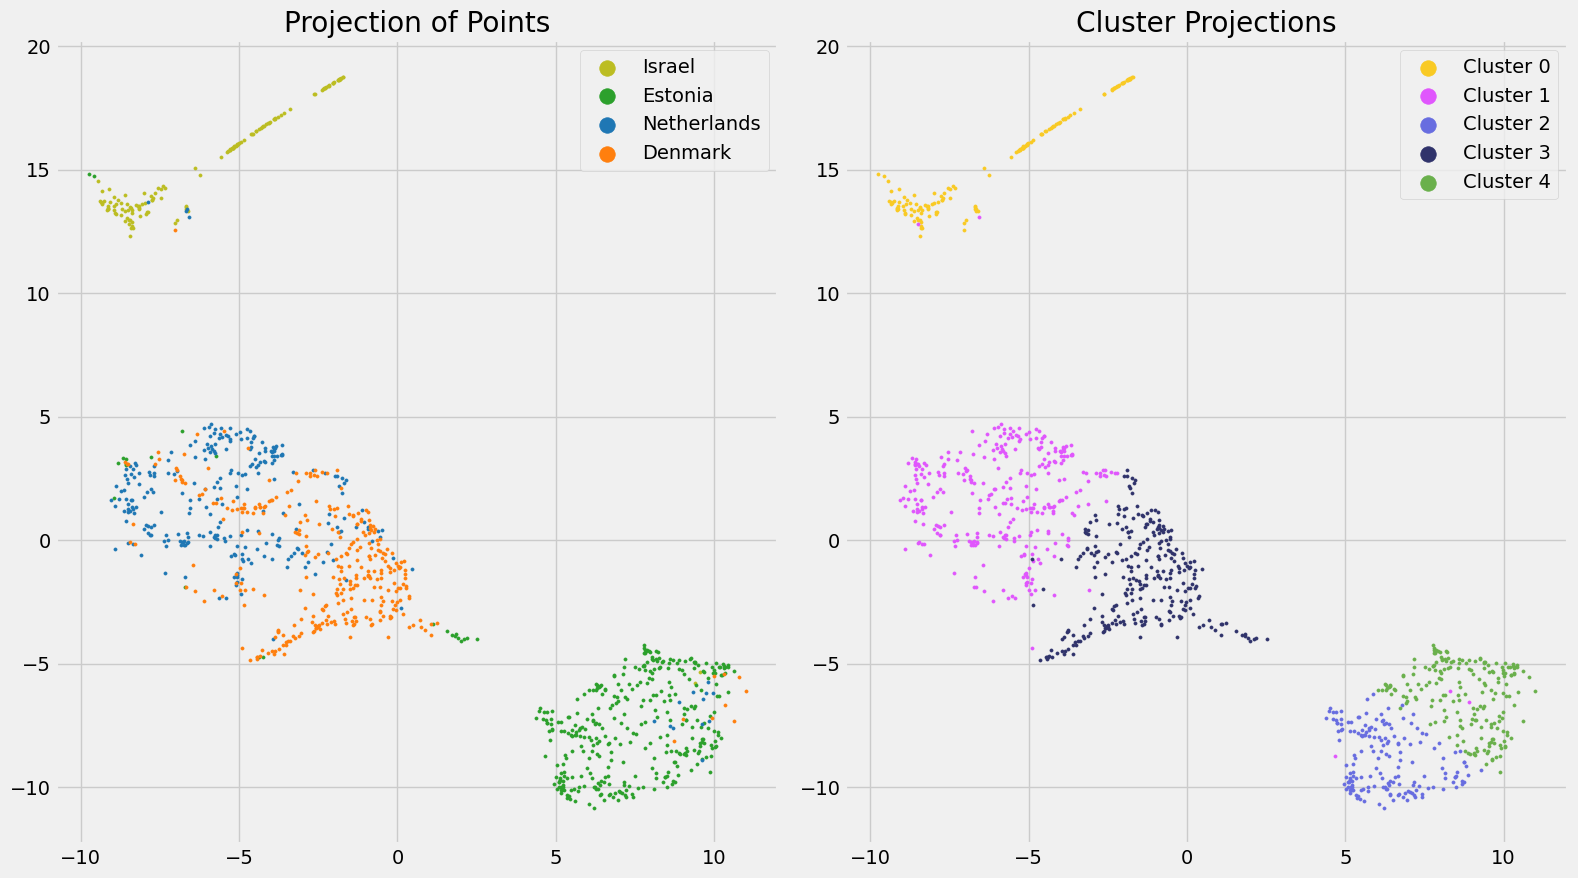

In [16]:
plot.projection_and_clusters(
    X_transformed=embeddings.project(X_scaled, n_components=2),
    projection_colors=reduced_colors,
    cluster_colors=clustered.labels_,
)

In [17]:
Counter([country for _, (country, _) in index_2_chip.items()])

Counter({'Estonia': 379, 'Denmark': 330, 'Netherlands': 280, 'Israel': 142})

In [18]:
len([country for _, (country, _) in index_2_chip.items()]) == len(
    reduced_colors
) == len(clustered.labels_)

True

Saving plot to /Users/viktorduepedersen/Documents/github/thesis/plots/embeddings/countries_per_cluster.png


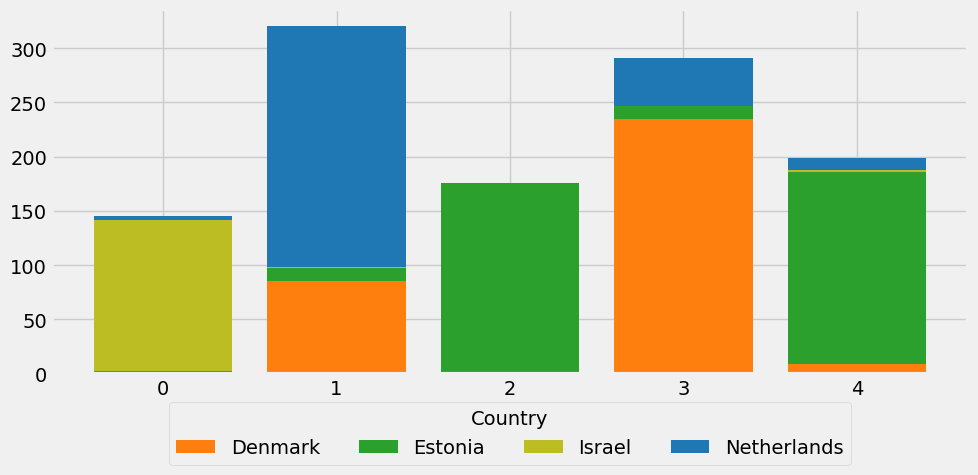

In [19]:
plot.distribution_of_countries_per_cluster(clustered.labels_, index_2_chip)

# Generate TFIDF-inspired scores for each of the clusters


In [20]:
from src.embeddings import cluster_analysis

In [21]:
cluster_LCs = cluster_analysis.generate_cluster_LC(
    cluster_labels=clustered.labels_, index_2_chip=index_2_chip
)

In [22]:
# # Generate sankey charts for each cluster

# titles = [
#     f"Cluster {cluster_id} - {cluster_df["changed_area"].sum():.0f} km²"
#     for cluster_id, cluster_df in cluster_LCs.items()
# ]

# plot.sankey_for_cluster_LCs(cluster_LCs, titles)

In [23]:
cluster_scores, tfidf_scores, from_to_count = cluster_analysis.generate_cluster_TFIDF(
    cluster_LCs
)

Saving plot to /Users/viktorduepedersen/Documents/github/thesis/plots/embeddings/tfidf_cluster_0.png
Saving plot to /Users/viktorduepedersen/Documents/github/thesis/plots/embeddings/tfidf_cluster_1.png
Saving plot to /Users/viktorduepedersen/Documents/github/thesis/plots/embeddings/tfidf_cluster_2.png
Saving plot to /Users/viktorduepedersen/Documents/github/thesis/plots/embeddings/tfidf_cluster_3.png
Saving plot to /Users/viktorduepedersen/Documents/github/thesis/plots/embeddings/tfidf_cluster_4.png


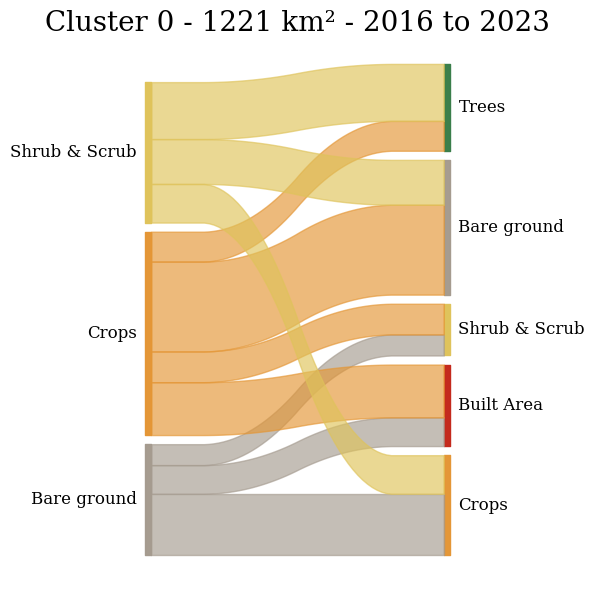

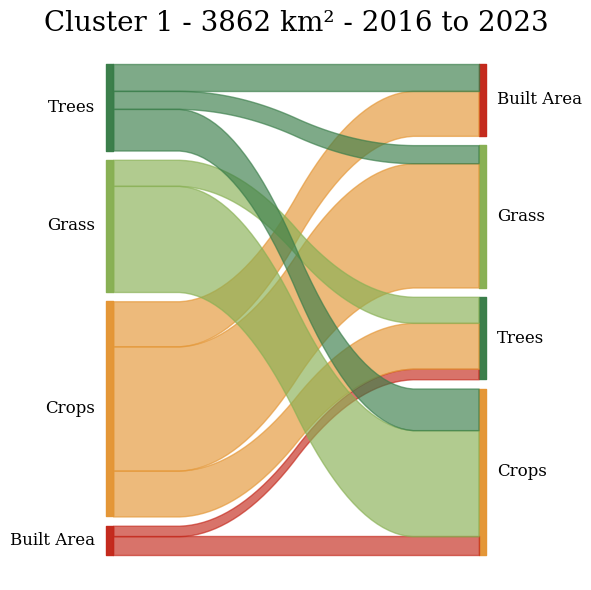

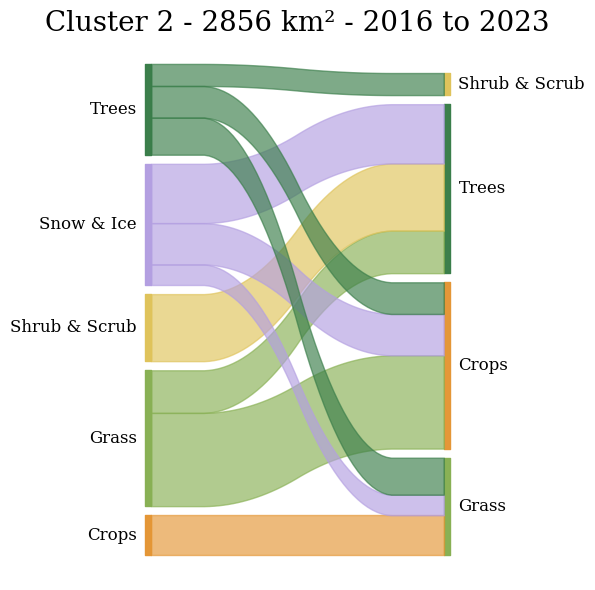

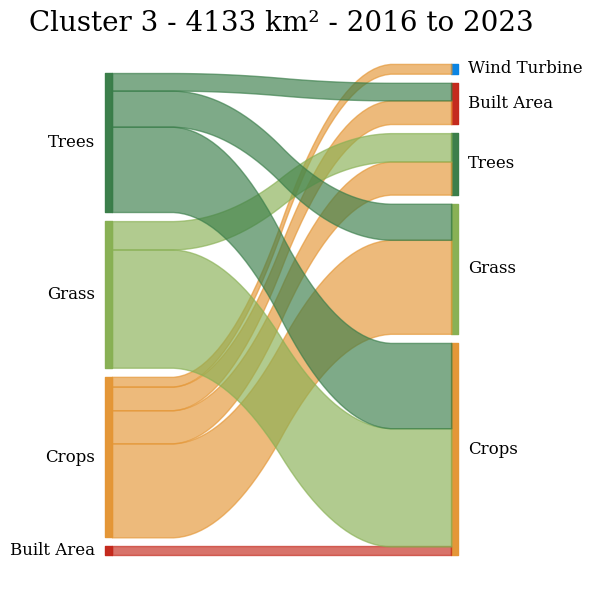

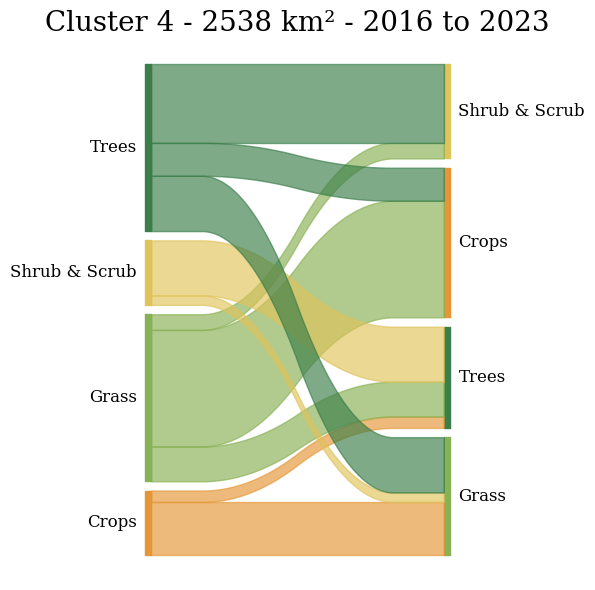

In [27]:
top_n_tfidf_cluster_LCs = {}

for cluster_id, cluster_df in cluster_scores.items():
    cluster_df.sort_values("tfidf_score", ascending=False, inplace=True)
    top_n_tfidf_cluster_LCs[cluster_id] = cluster_df.head(10)

# generate titles
titles = [
    f"Cluster {cluster_id} - {cluster_df["changed_area"].sum():.0f} km²"
    for cluster_id, cluster_df in top_n_tfidf_cluster_LCs.items()
]

plot.sankey_for_cluster_LCs(top_n_tfidf_cluster_LCs, titles=titles, tfidf_edition=True)